In [142]:
# using Pkg
# Pkg.activate("/home/jek354/research/ML-signproblem")
# Pkg.update()

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON
using OptimizationOptimJL
using ExponentialUtilities
using JLD2
using KrylovKit
# using ExponentialUtilities


include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")
# include("adiabatic_analysis.jl")

merge_jld2_folder

In [239]:

N_up = 2
N_down = 2
N =  5
half_filling = false
# lattice = Chain(6, Periodic())
lattice_dimension = (2,3)
bc = "periodic"
# lattice = Chain(6, Periodic())
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
# lattice = Graphs.cycle_graph(3)

hopping_model = HubbardModel(1.0,0.0,0.0,false)
interaction_model = HubbardModel(0.0,1.0,0.0,false)

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

H_hopping, indexer = create_Hubbard(hopping_model, subspace; get_indexer=true)
H_interaction = create_Hubbard(interaction_model, subspace; indexer=indexer);


In [240]:
include("ed_functions.jl")
n_eigs = collect(lattice_dimension)

eig_indices = [1,1]
mapping = []
s_mapping = []
for kind in 1:2
    op = create_operator(subspace,:T, kind=kind)
    r, c, v = findnz(op)
    push!(mapping, r)
    push!(s_mapping, v)
end


checked_indices, representative_indices, associated_representative, magnitude = find_representatives(size(H_hopping)[1], eig_indices, n_eigs, mapping, s_mapping)
symmetrize(h) = construct_hamiltonian(
    findnz(h)...; 
    checked_indices, representative_indices, associated_representative, 
    magnitude, n_eigs, eig_indices
)
new_hopping = symmetrize(H_hopping)
new_interaction = symmetrize(H_interaction)

ops = []
eig_values = []
if subspace.N >= 1
    particle_n = subspace.N 
    push!(ops,Hermitian(symmetrize(create_operator(subspace,:Sx))))
    push!(eig_values, -particle_n÷2:1:particle_n÷2)
    push!(ops,Hermitian(symmetrize(create_operator(subspace,:∏σx))))
    push!(eig_values, -1:2:1)
    push!(ops, Hermitian(symmetrize(create_operator(subspace,:S2))))
    push!(eig_values, [s*(s+1) for s in (particle_n%2)/2:1:particle_n/2])
else
    push!(ops, Hermitian(symmetrize(create_operator(subspace,:S2))))
    particle_n = subspace.N_up + subspace.N_down
    push!(eig_values, [s*(s+1) for s in (particle_n%2)/2:1:particle_n/2])
end



new_h = new_hopping + new_interaction * 0.20309176209047358
E, H_vecs = eigsolve(new_h, rand(ComplexF64, size(new_h)[1]), 5, :SR)
println(E)
v = reconstruct_full_vector(H_vecs[1], mapping, s_mapping, representative_indices, magnitude, eig_indices, n_eigs);
# println(sum(abs2, vec))
# for (op, eigs, i) in zip(ops, eig_values, [1,3])
#     vec = project!(op, vec, i, eigs)
#     break
# end
# println(sum(abs2,vec))
# vec'*ops[1]*vec


[-7.899642591579688, -7.862346837068069, -7.831479785664002, -7.799250784475894, -7.757446803292224, -7.731266898633596, -7.7086462954872745, -4.798101698878634, -4.797470372396607]


792-element Vector{ComplexF64}:
 -1.1687153941434025e-17 - 2.080793873192548e-17im
 -1.1687153941434025e-17 - 2.080793873192548e-17im
  1.1687153941434025e-17 + 2.080793873192548e-17im
  1.1687153941434025e-17 + 2.080793873192548e-17im
 -1.1687153941434025e-17 - 2.080793873192548e-17im
 -1.1687153941434025e-17 - 2.080793873192548e-17im
   -6.184679720410724e-5 + 3.100617722024143e-5im
 -5.2264128423949515e-17 - 8.867178522374085e-17im
   1.2243575855539962e-5 - 6.138175296969612e-6im
   1.2243575855661188e-5 - 6.138175296772778e-6im
                         ⋮
  -0.0001591299411674543 - 0.00013023114937958433im
  0.00015912994116745686 + 0.00013023114937957996im
  0.00015912994116745686 + 0.00013023114937957996im
 -1.4345477765324727e-17 - 1.5625533489195775e-17im
 -1.4345477765324727e-17 - 1.5625533489195775e-17im
  1.4345477765324727e-17 + 1.5625533489195775e-17im
  1.4345477765324727e-17 + 1.5625533489195775e-17im
 -1.4345477765324727e-17 - 1.5625533489195775e-17im
 -1.43454777653247

In [108]:

dic = load_saved_dict("data/test/meta_data_and_E.jld2")

meta_data = dic["meta_data"]
U_values = meta_data["U_values"]
all_eig_vecs = dic["all_eig_vecs"]
mapping = dic["mapping"]
s_mapping = dic["s_mapping"]
representative_indices = dic["representative_indices"]
magnitude = dic["magnitude"]
_eig_indices = meta_data["translational symmetry"]
_n_eigs = [parse(Int,x) for x in split(meta_data["sites"], "x")]
degen_rm_U = reconstruct_full_vector(
     all_eig_vecs[20,:], 
     mapping, s_mapping, representative_indices, magnitude, eig_indices, n_eigs
)
degen_rm_U'*(H_hopping + H_interaction*0.20309176209047358)*degen_rm_U


AssertionError: AssertionError: File does not exist: data/test/meta_data_and_E.jld2

In [61]:
println(v'*(H_hopping + H_interaction*0.20309176209047358)*v)
dic = load_saved_dict("data/test/meta_data_and_E.jld2")
# sum(abs2,H_vecs[1] - dic["all_eig_vecs"][20,:])

abs(dic["all_eig_vecs"][20,:]'*H_vecs[1])

-11.70014726836269 - 1.1789075193003399e-33im


0.9999999999999998

In [ ]:
for k in eachindex(representative_indices)
    vec = zeros(length(representative_indices))
    vec[k] = 1
    new_vec = reconstruct_full_vector(vec, mapping, s_mapping, representative_indices, magnitude, eig_indices, n_eigs)
    if !(sum(abs2,new_vec ) ≈ 1)
        println("$k $(sum(abs2,new_vec)) $(magnitude[k]) $(sum(abs.(new_vec) .> 1e-10))")
    end
end

In [ ]:
println(eigsolve(new_h, rand(ComplexF64, size(new_h)[1]), 2, :SR)[1][1])
vec = eigsolve(new_h, rand(ComplexF64, size(new_h)[1]), 2, :SR)[2][1]

-11.700147268362674


68-element Vector{ComplexF64}:
   -0.001370195715808449 - 0.0020378592224381824im
  -0.0014015730318187906 - 0.002084525951920145im
  -0.0012849359211483777 - 0.0019110543748924764im
   0.0012968420392085764 + 0.0019287620587019702im
 -0.00027431693187922936 - 0.0004079849929842876im
  -2.2131594568838168e-6 - 3.2915789751401895e-6im
  -0.0016863804296232295 - 0.002508113163249191im
  -0.0007136886835714817 - 0.0010614520604511853im
    0.002448170624859238 + 0.0036411054482303083im
  -0.0007159814985955938 - 0.0010648621092406464im
                         ⋮
     0.17391855853353816 + 0.2586649004749162im
     0.16752514192002982 + 0.24915612529892525im
     0.17944570959251552 + 0.26688529967000607im
    -0.17287497039992133 - 0.2571127968754216im
   -0.002448170624858975 - 0.003641105448229991im
   0.0007136886835713888 + 0.0010614520604509325im
   0.0007072623675469391 + 0.0010518943547702883im
  -0.0023843796779291515 - 0.0035462307029589897im
     0.00244817062485906 + 0.00364110

In [29]:
dic

Dict{String, Any} with 8 entries:
  "meta_data"              => Dict{String, Any}("U_values"=>[1.0e-5, 0.001, 0.0…
  "representative_indices" => Any[2, 3, 4, 5, 6, 7, 39, 40, 44, 45  …  704, 705…
  "indexer"                => CombinationIndexer{Coordinate{2, Int64}}(Coordina…
  "mapping"                => Any[[1, 9, 8, 11, 10, 13, 12, 3, 2, 5  …  920, 92…
  "all_eig_vecs"           => ComplexF64[-2.73324e-17-1.89795e-17im -3.97329e-1…
  "s_mapping"              => Any[[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0,…
  "E"                      => Any[-12.0, -11.9985, -11.998, -11.9973, -11.9964,…
  "magnitude"              => Any[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, …

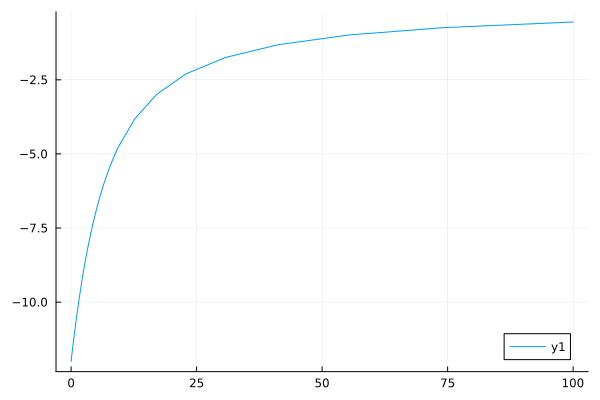

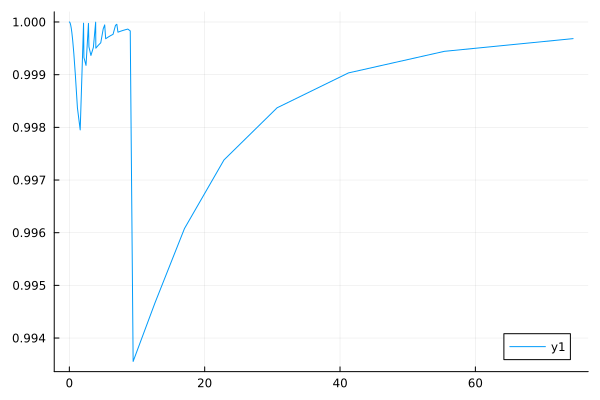

In [35]:
dic = load_saved_dict("data/test/meta_data_and_E.jld2")
display(plot(dic["meta_data"]["U_values"], dic["E"]))

plot(dic["meta_data"]["U_values"][1:end-1],[abs.(dic["all_eig_vecs"][i,:]'*dic["all_eig_vecs"][i+1,:]) for i in 1:length(dic["meta_data"]["U_values"])-1])

# Projectors

In [246]:
H_vecs[1]'*ops[1]*H_vecs[1]

0.4608419933279049 + 2.0325527674019887e-18im

In [ ]:
function project_hermitian(H, v::AbstractVector, target_eig::Real, all_eigs::Vector{<:Real}; safety_factor=1.1)
    
    # 1. Analyze Spectral Properties
    E_min, E_max = minimum(all_eigs), maximum(all_eigs)
    spectral_width = E_max - E_min
    
    # Calculate the smallest gap between target and any other eigenvalue
    # Filter out the target itself to avoid finding a gap of 0
    other_eigs = filter(e -> !isapprox(e, target_eig, atol=1e-9), all_eigs)
    
    if isempty(other_eigs)
        return v # If there's only 1 eigenvalue, v is already in the eigenspace
    end
    
    min_gap = minimum(abs.(other_eigs .- target_eig))
    
    # 2. Determine Sampling Parameters
    
    # Time step dt: Nyquist limit to avoid aliasing the spectrum
    # We add a small buffer (+1e-5) to spectral_width to ensure we are strictly below Nyquist
    dt = 2 * π / (spectral_width + 1.0)
    
    # Total time T: Required to resolve the smallest energy gap
    # Uncertainty principle: Time * Energy ~ 2π
    T_required = (2 * π / min_gap) * safety_factor
    
    # Number of steps K
    K = ceil(Int, T_required / dt)

    # 3. Perform the Projection Sum
    # P = (1/K) * sum_{k=0}^{K-1} exp(-i * t_k * target) * exp(i * t_k * H)
    
    v_proj = zero(v)
    
    # We use a rectangular window here. 
    # Note: For very crowded spectra, a Gaussian window (tapering coefficients) 
    # would suppress spectral leakage better, but rectangular is the standard "sum".
    for k in 1:K-1
        t = k * dt
        
        # Coefficient: cancel the phase of the target eigenvalue
        # c_k = exp(-i * \lambda_{target} * t)
        coeff = exp(-im * target_eig * t)
        
        # Evolution: exp(i * H * t) * v
        v_evolved = expv(im * t, H, v)
        
        v_proj .+= coeff .* v_evolved
    end
    
    return normalize(v_proj)
end

# H_vecs[1]'*new_h*H_vecs[1]
println(H_vecs[1]'*ops[1]*H_vecs[1])
println(H_vecs[1]'*ops[3]*H_vecs[1])
tmp = project(ops[1], H_vecs[1], 1.5, collect((-N/2):N/2))
println(tmp'*ops[1]*tmp)
println(tmp'*ops[3]*tmp)

0.4608419933279049 + 2.0325527674019887e-18im
3.7499999999999982 - 6.443014308312151e-17im
1.5000000000000002 - 1.6494570230296346e-17im
3.750000000000001 - 2.829576487215752e-17im


In [115]:
dic = load_saved_dict("data/N=3_2x3/meta_data_and_E.jld2")

meta_data = dic["meta_data"]
U_values = meta_data["U_values"]
all_eig_vecs = dic["all_eig_vecs"]
mapping = dic["mapping"]
s_mapping = dic["s_mapping"]
representative_indices = dic["representative_indices"]
magnitude = dic["magnitude"]
eig_indices = meta_data["translational symmetry"]
n_eigs = [parse(Int,x) for x in split(meta_data["sites"], "x")]
degen_rm_U = reconstruct_full_vector(
     all_eig_vecs, 
     mapping, s_mapping, representative_indices, magnitude, eig_indices, n_eigs
)
indexer = dic["indexer"]

all_eig_vecs[1,:]'*ops[1]*all_eig_vecs[1,:]

-0.2478506521045995 + 1.0197474822606335e-17im

In [214]:
"""
    project_Sx(Sx, v, m, N)

Project the vector `v` onto the eigenstate of the operator `Sx` 
corresponding to eigenvalue `m` using the discrete Fourier projection method.

Arguments:
- `Sx`: The sparse Hermitian operator (Spin-x).
- `v`: The input vector to project.
- `m`: The target eigenvalue (must be in -N/2 : 1 : N/2).
- `N`: The parameter defining the spectral range (total spin is N/2).
"""
function project_Sx(Sx, v::AbstractVector, m::Real, N::Real)
    # The spectral width is N. By Nyquist theorem, we need K > N sample points 
    # to distinguish all eigenvalues.
    K = Int(N) + 2 
    
    # Initialize the accumulator for the projected vector
    # Result will likely be complex
    v_proj = zeros(ComplexF64, length(v))

    # Perform the sum: P_m = (1/K) * sum_{k} exp(-i * theta_k * m) * exp(i * theta_k * Sx)
    for k in 0:K-1
        # Define the rotation angle theta_k = 2*pi*k / K
        theta = 2 * π * k / K
        
        # Calculate the scalar phase factor: exp(-i * theta * m)
        phase_factor = exp(-im * theta * m)
        
        # Calculate the vector rotation: exp(i * theta * Sx) * v
        # We use expv(t, A, v) which computes exp(t*A)*v efficiently using Krylov subspaces
        # Here t = i * theta, A = Sx
        v_rotated = expv(im * theta, Sx, v)
        
        # Accumulate the weighted term
        v_proj .+= phase_factor .* v_rotated
    end

    # Normalize by 1/K
    return v_proj ./ K
end

# --- Helper Function for Demonstration ---

"""
    construct_Sx(N)

Constructs the sparse Sx operator for a spin-J particle where J = N/2.
Dimension of the matrix is N+1.
"""
function project_Sx(Sx, v::AbstractVector, m::Real, N::Real)
    # 1. Validation: Ensure m is a valid eigenvalue for N
    # For N=1 (Spin 1/2), m must be +/- 0.5. For N=2, m must be -1, 0, 1.
    if mod(N, 2) == 0
        is_valid_m = isinteger(m)
    else
        is_valid_m = isinteger(m + 0.5)
    end
    
    if !is_valid_m
        error("Invalid target m=$m for N=$N. m must be consistent with Spin-$(N/2).")
    end

    # 2. Sampling Setup
    # The spectral width is N. 
    # For 4π periodicity, we need double the sampling density of the standard 2π loop.
    # Safe heuristic: K > 2*N to resolve all phases over 4π.
    K = 2 * Int(N) + 4
    
    v_proj = zeros(ComplexF64, length(v))

    # 3. Summation over 4π
    for k in 0:K-1
        # Range theta: 0 to 4π
        theta = 4 * π * k / K
        
        # Phase factor: e^(-i * theta * m)
        phase_factor = exp(-im * theta * m)
        
        # Rotation: e^(i * theta * Sx)
        # Note: For odd N, this rotation has 4π periodicity
        v_rotated = expv(im * theta, Sx, v)
        
        v_proj .+= phase_factor .* v_rotated
    end

    # Normalize by 1/K
    return v_proj ./ K
end

# --- Usage Example ---

# 1. Setup system parameters
N = 9                  # Total spin N/2 = 5
dim = N + 1
Sx = construct_Sx(N)    # Create sparse Sx operator

# 2. Create a random initial state vector
v_random = normalize(randn(ComplexF64, dim))

# 3. Choose a target eigenvalue of Sx to project onto
#    Valid values are -5.0, -4.0, ..., 5.0
target_m = 2.0 

println("Projecting random vector onto Sx eigenstate with m = $target_m...")

# 4. Perform the projection
psi_m = project_Sx(Sx, v_random, target_m, N)

# 5. Verify the result
#    If psi_m is an eigenstate, then Sx * psi_m should equal target_m * psi_m
norm_psi = norm(psi_m)

if norm_psi < 1e-10
    println("Projection resulted in zero vector (input likely had 0 overlap with target).")
else
    psi_m = normalize(psi_m)
    expectation = dot(psi_m, Sx, psi_m)
    residue = norm(Sx * psi_m - target_m * psi_m)
    
    println("Result Norm:      $norm_psi")
    println("Expectation <Sx>: $expectation")
    println("Residue |(Sx - m)v|: $residue")
end

Projecting random vector onto Sx eigenstate with m = 2.0...


ErrorException: Invalid target m=2.0 for N=9. m must be consistent with Spin-4.5.

In [208]:
eigvals(Matrix(Sx))

10-element Vector{Float64}:
 -4.500000000000002
 -3.5
 -2.4999999999999987
 -1.5
 -0.4999999999999999
  0.49999999999999994
  1.4999999999999991
  2.4999999999999996
  3.499999999999999
  4.499999999999997

In [209]:
exp(1im*2π*Matrix(Sx))

10×10 Matrix{ComplexF64}:
         -1.0+0.0im          …           0.0+1.34364e-16im
          0.0+8.07548e-16im     -2.89503e-16+0.0im
  4.65693e-17+0.0im                      0.0+3.90418e-16im
          0.0-3.18274e-17im      3.70943e-17+0.0im
  1.02707e-16+0.0im                      0.0+1.49645e-17im
          0.0+1.49645e-17im  …   1.02707e-16+0.0im
  3.70943e-17+0.0im                      0.0-3.18274e-17im
          0.0+3.90418e-16im      4.65693e-17+0.0im
 -2.89503e-16+0.0im                      0.0+8.07548e-16im
          0.0+1.34364e-16im             -1.0+0.0im